In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from itertools import product                    
from tqdm import tqdm_notebook
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler


In [4]:
xly = pd.read_csv("stock_data/xly_data2.csv")
xly.head()

,Date,High,Low,Open,XLY,Volume,Adj Close,DlyRtn
0,1/4/1999,26.53125,25.906250,26.15625,25.96875,5200,20.310123,NaN
1,1/5/1999,26.40625,26.125000,26.12500,26.40625,1300,20.652287,1.684692
2,1/6/1999,27.15625,26.718750,26.71875,27.15625,8100,21.238859,2.840231
3,1/7/1999,27.31250,27.000000,27.03125,27.12500,13700,21.214430,-0.115022
4,1/8/1999,27.40625,27.109381,27.28125,27.15625,18600,21.238859,0.115154


In [5]:
xly = xly.iloc[124:] #setting the data to range from 7/1/1999 to 7/1/2019

In [6]:
def set_index(df):
    """This function sets the Date to the index, drops the Date column
    and converts the index to datetime format"""
    df.set_index(df['Date'], inplace=True)
    df.drop(['Date'], axis=1, inplace=True)
    pd.to_datetime(df.index)

In [7]:
set_index(xly)
xly.head()

,High,Low,Open,XLY,Volume,Adj Close,DlyRtn
Date,,,,,,,
7/1/1999,29.937500,29.56250,29.56250,29.93750,2900,23.471066,0.524655
7/2/1999,30.250000,29.81250,29.81250,30.09375,10900,23.593555,0.521876
7/6/1999,30.578119,30.15625,30.18750,30.34375,17000,23.789568,0.830788
7/7/1999,30.250000,30.06250,30.21875,30.06250,20000,23.569057,-0.926921
7/8/1999,30.125000,29.71875,29.71875,29.81250,4200,23.373058,-0.831595


In [8]:
data = xly

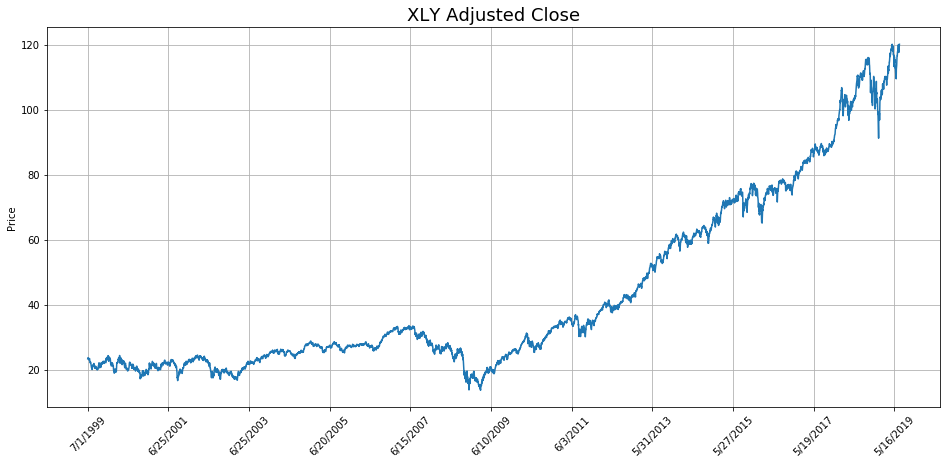

In [9]:
def close_plot(df, column, title):    
    plt.figure(figsize=(16,7))
    plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
    plt.plot(df[column])
    plt.grid(True)
    plt.ylabel('Price')
    plt.title(title, fontsize=18)
    plt.show()
close_plot(data, 'Adj Close',  'XLY Adjusted Close')

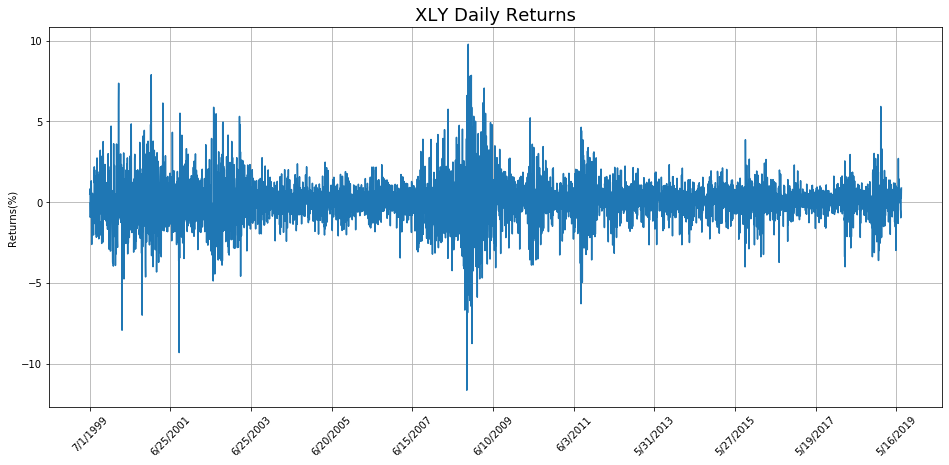

In [10]:
def return_plot(df, column, title):    
    plt.figure(figsize=(16,7))
    plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
    plt.ylabel('Returns(%)')
    plt.plot(df[column])
    plt.grid(True)
    plt.title(title, fontsize=18)
    plt.show()
return_plot(data, 'DlyRtn',  'XLY Daily Returns')

In [11]:
data.iloc[4907]  #first trading day of 2018

High         1.003200e+02
Low          9.679000e+01
Open         9.732000e+01
XLY          9.976000e+01
Volume       6.840800e+06
Adj Close    9.907914e+01
DlyRtn       7.574986e-01
Name: 1/2/2019, dtype: float64

In [12]:
data.iloc[4907] #first trading day of 2019

High         1.003200e+02
Low          9.679000e+01
Open         9.732000e+01
XLY          9.976000e+01
Volume       6.840800e+06
Adj Close    9.907914e+01
DlyRtn       7.574986e-01
Name: 1/2/2019, dtype: float64

In [13]:
# def mid_price(df):   
#     high_prices = df.loc[:,'High'].as_matrix()
#     low_prices = df.loc[:,'Low'].as_matrix()
#     mid_prices = (high_prices+low_prices)/2.0
#     return mid_prices

In [14]:
train_data = data.DlyRtn[:4907].as_matrix()
test_data = data.DlyRtn[4907:].as_matrix()

In [15]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [16]:
smoothing_window_size = 900
for di in range(0,4500,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


In [17]:
#normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [18]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

In [19]:
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [20]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4907):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA


In [21]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

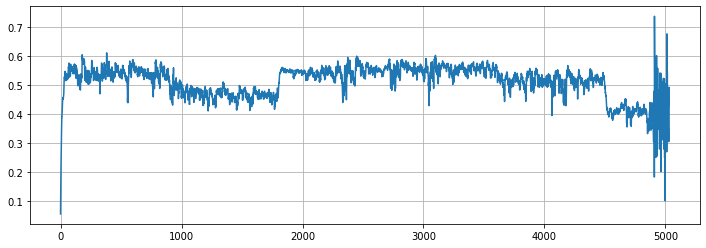

In [22]:
plt.figure(figsize=(12,4))
plt.plot(all_mid_data)
plt.grid(True)
plt.show()

In [23]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00026


In [24]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    #run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00007


In [25]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.057143   0.49174848 0.5475791  0.5518093  0.49981922]

	Output: [0.18965839 0.511849   0.5507516  0.54707325 0.5483462 ]


Unrolled index 1
	Inputs:  [0.10855553 0.48767483 0.5526386  0.5412285  0.512081  ]

	Output: [0.2520395  0.50542355 0.5483413  0.5362434  0.5386821 ]


Unrolled index 2
	Inputs:  [0.15662433 0.5068106  0.5507516  0.54707325 0.5386821 ]

	Output: [0.18965839 0.5068106  0.5525786  0.52997565 0.5386821 ]


Unrolled index 3
	Inputs:  [0.18965839 0.511849   0.5483413  0.5362434  0.5440746 ]

	Output: [0.29933292 0.511849   0.5509369  0.5236047  0.5440746 ]


Unrolled index 4
	Inputs:  [0.21994375 0.50542355 0.5525786  0.52997565 0.5483462 ]

	Output: [0.21994375 0.4876355  0.5509369  0.52997565 0.5483462 ]


### Defining Hyperparameters 

In [26]:
D = 1 # Dimensionality of the data
num_unrollings = 50 # Number of time steps looking into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [250,200,100] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() #important for running this multiple times

In [27]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [28]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [29]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [30]:

print('Defining Training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning Rate Decay Operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining Training Loss
Learning Rate Decay Operations
TF Optimization operations
	All done


In [31]:
print('Defining Prediction Related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining Prediction Related TF functions
	All done


In [32]:
epochs = 30
valid_summary = 1 # Interval to make test predictions

n_predict_once = 25 # Number of steps to continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points to start test predictions from
test_points_seq = np.arange(4907,5032,25).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
                x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current_price = all_mid_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):

                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

Initialized
Average loss at step 1: 3.221719
	Test MSE: 0.01518
	Finished Predictions
Average loss at step 2: 0.332733
	Test MSE: 0.01260
	Finished Predictions
Average loss at step 3: 0.120625
	Test MSE: 0.00471
	Finished Predictions
Average loss at step 4: 0.071761
	Test MSE: 0.00528
	Finished Predictions
Average loss at step 5: 0.057258
	Test MSE: 0.00577
	Finished Predictions
Average loss at step 6: 0.052723
	Test MSE: 0.00465
	Finished Predictions
Average loss at step 7: 0.048175
	Test MSE: 0.00507
	Finished Predictions
Average loss at step 8: 0.045026
	Test MSE: 0.00521
	Finished Predictions
Average loss at step 9: 0.043966
	Decreasing learning rate by 0.5
	Test MSE: 0.00488
	Finished Predictions
Average loss at step 10: 0.042766
	Test MSE: 0.00493
	Finished Predictions
Average loss at step 11: 0.042330
	Test MSE: 0.00503
	Finished Predictions
Average loss at step 12: 0.040522
	Decreasing learning rate by 0.5
	Test MSE: 0.00493
	Finished Predictions
Average loss at step 13: 0.0406

In [33]:
round(min(test_mse_ot), 5) #Lowest test MSE

0.00465

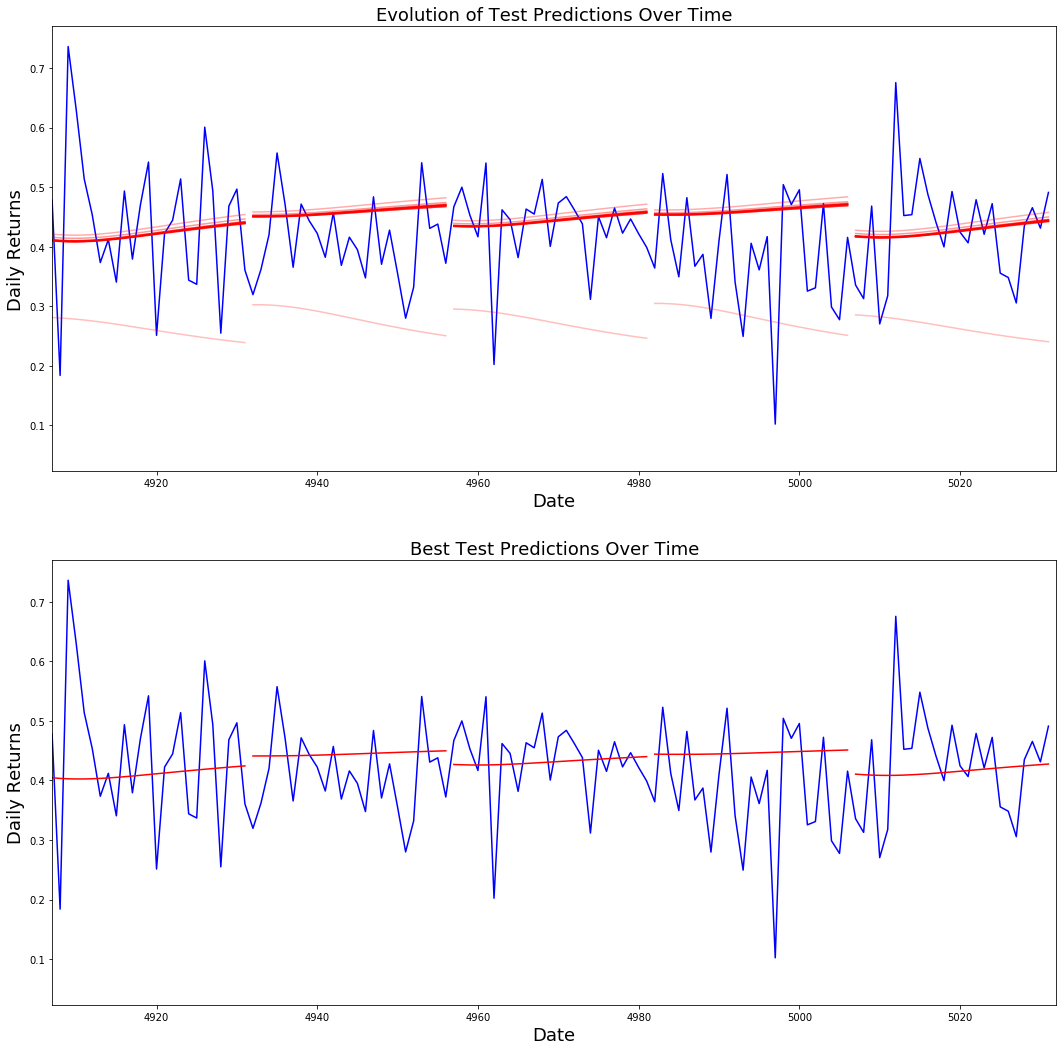

In [34]:
best_prediction_epoch = 5
plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Returns',fontsize=18)
plt.xlim(4907,5032)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Returns',fontsize=18)

plt.xlim(4907,5032)
plt.show() 

In [35]:
array = predictions_over_time[best_prediction_epoch] #arrays of scaled predictions

In [36]:
def pred_df(arraylist, test_data):
    """combines scaled prediction data and test data 
    into one one dataframe"""
    array = [x for y in arraylist for x in y]
    testdata = list(test_data)
    pred = pd.DataFrame(testdata, array)
    pred.reset_index(inplace=True)
    pred.rename(index=str, columns={ 'index': 'test_data', 0: 'predictions' }, inplace=True)
    return pred 

In [37]:
pred = pred_df(array, test_data)

In [38]:
def unscaled_pred_df(df, df_pred):
    """Unscales data and returns a preliminary graph comparing 
    predictions to test data"""
    
    train_data_new = df.DlyRtn[:4907].as_matrix()
    test_data_new = df.DlyRtn[4907:].as_matrix()


    for i in range(0, df_pred.shape[0], 4):
        scaler.fit(np.append(train_data_new[-500+i:], test_data_new[i-4:i], axis=0).reshape(-1, 1))
        df_pred.loc[i:i+4, 'Predictions'] = scaler.inverse_transform(df_pred.predictions[i:i+4].values.reshape(-1,1)).reshape(-1,)

    df_pred['Unscaled_Test']  = test_data_new
    df_pred = df_pred.drop(['test_data', 'predictions'], axis=1)
    
    return df_pred.plot(figsize=(14, 4))

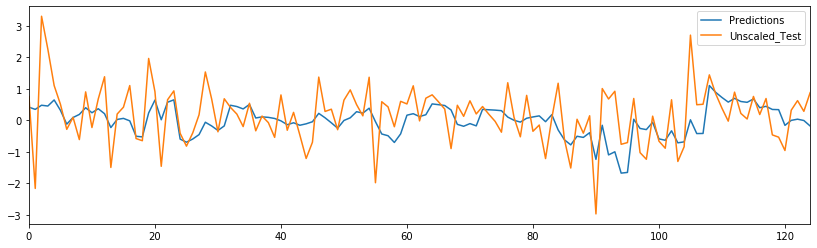

In [39]:
unscaled_pred_df(data, pred);

In [40]:
def prediction_df(etf, pred_data):    
    new_etf = etf.iloc[4907:] 
    new_etf.reset_index(inplace=True)
    pred_data.reset_index(inplace=True)
    dataframe = pd.concat([new_etf, pred_data], axis=1)
    dataframe2 = dataframe[['Date', 'DlyRtn', 'Predictions']]
    set_index(dataframe2)
    
    return dataframe2

In [41]:
xly_pred = prediction_df(data, pred)
xly_pred.head()

,DlyRtn,Predictions
Date,,
1/2/2019,0.757499,0.418585
1/3/2019,-2.165202,0.348281
1/4/2019,3.309433,0.479970
1/7/2019,2.261228,0.454756
1/8/2019,1.105613,0.647714


In [42]:
def month_preds(pred_data, pred_column, new_column_name):   
    pred_data.index = pd.to_datetime(pred_data.index)
    month_dates = pd.date_range('1/1/2019', periods=6, freq='BM')
    jan = ((pred_data[pred_column][0:21]/100) + 1).product() #jan
    feb = ((pred_data[pred_column][21:40]/100) + 1).product() #Feb
    mar = ((pred_data[pred_column][40:61]/100)+1).product()       #March 
    apr = ((pred_data[pred_column][61:82]/100)+1).product() #April
    may = ((pred_data[pred_column][82:104]/100)+1).product() #May 
    june = ((pred_data[pred_column][104:124]/100)+1).product() #June
    month_list = [jan, feb, mar, apr, may, june]
    df = pd.DataFrame(month_list, month_dates, columns=[new_column_name])
    return df

In [43]:
month_preds(xly_pred, 'Predictions', 'XLF_Pred')

,XLF_Pred
2019-01-31,1.037893
2019-02-28,1.002727
2019-03-29,0.984601
2019-04-30,1.034656
2019-05-31,0.880248
2019-06-28,1.058872


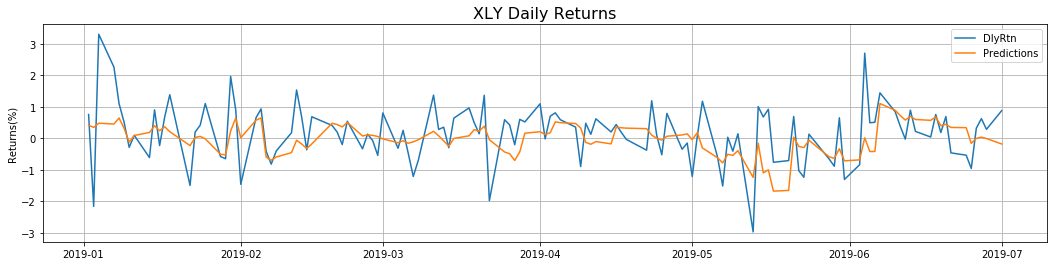

In [46]:
def daily_returns(pred_df, title):    
    plt.figure(figsize=(18,4))
    plt.title(title, fontsize=16)
    plt.plot(pred_df[['DlyRtn', 'Predictions']])
    plt.ylabel('Returns(%)')
    plt.legend(pred_df[['DlyRtn', 'Predictions']])
    plt.grid()
    plt.show()
daily_returns(xly_pred, 'XLY Daily Returns')

In [47]:
def monthly_df(pred_df, pred_column):
    predictions = month_preds(pred_df, 'Predictions', pred_column)
    actual_returns = month_preds(pred_df, 'DlyRtn', 'Actual Returns')
    new_df = pd.concat([predictions, actual_returns], axis=1)
    percent_df = (new_df -1)*100
    percent_df['Difference'] = abs(percent_df[pred_column] - percent_df['Actual Returns'])
    return percent_df

monthly_df(xly_pred, 'XLY_Pred')

,XLY_Pred,Actual Returns,Difference
2019-01-31,3.789315,9.867686,6.078371
2019-02-28,0.272672,1.314582,1.041910
2019-03-29,-1.539935,3.655289,5.195223
2019-04-30,3.465622,5.463325,1.997703
2019-05-31,-11.975201,-7.603894,4.371307
2019-06-28,5.887207,7.815914,1.928707
